In [14]:
import json
from pathlib import Path
from typing import Sequence, TypeAlias

import numpy as np
from matplotlib import pyplot as plt

from gossiplearning import History

N_SIMULATIONS = 10
N_NODES = 10
N_STEPS = 20
STEP_SIZE = 5

colors = ["blue", "green", "orange", "red", "purple"]

MSE: TypeAlias = float
Variance: TypeAlias = float

experiments = {
    # NOT SCALED

    "porto_80": "Weighted Overwrite",
    "porto_82": "Simple Average",
    "porto_83": "Overwrite",
    "porto_84": "Weighted Average",
    "porto_86": "Avg 0.2",
    "porto_87": "WAvg 0.2",
    "porto_88": "Ovw Opt",
    "porto_89": "impOvw opt",
    
    # # 1k
    # "porto_94": "Overwrite",
    # "porto_95": "Weighted Overwrite",
    # "porto_96": "Simple Average",
    # "porto_97": "Weighted Average",
}

histories = {
    exp: []
    for exp in experiments.keys()
}

for i in range(N_SIMULATIONS):
    for exp in experiments.keys():
        with open(
                f"../experiments/porto_taxi/{exp}/{i}/history.json", "r"
            ) as f:
            histories[exp].append(History(**json.load(f)))

In [15]:
def get_node_metric_by_epoch(history: History, metric: str = "mse") -> Sequence[Sequence[MSE]]:
    nodes_test_mses = [
        test_history[metric]
        for test_history in history.nodes_test_history.values()
    ]
    epochs_mses = [
        [nodes_test_mses[node][step] for node in range(N_NODES)]
        for step in range(N_STEPS)
    ]
    return epochs_mses

def get_node_training_metric_by_epoch(history: History, metric: str = "mse") -> Sequence[Sequence[MSE]]:
    nodes_test_mses = [
        test_history[metric]
        for test_history in history.nodes_training_history.values()
    ]
    epochs_mses = [
        [nodes_test_mses[node][step] for node in range(N_NODES)]
        for step in range(N_STEPS)
    ]
    return epochs_mses

In [16]:
mse = {
    exp: [
        get_node_metric_by_epoch(history)
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}

training_mse = {
    exp: [
        get_node_training_metric_by_epoch(history)
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}

In [17]:
def get_variances(mses: Sequence[Sequence[Sequence[MSE]]]) -> Sequence[Sequence[Variance]]:
    return [
        [
            (np.std(mses[sim][step]) * 100) / np.mean(mses[sim][step])
            # np.std(mses[sim][step])
            for step in range(N_STEPS)
        ]
        for sim in range(N_SIMULATIONS)
    ]

def get_averages(mses: Sequence[Sequence[Sequence[MSE]]]) -> Sequence[Sequence[MSE]]:
    return [[np.average(mses[sim][step]) for step in range(N_STEPS)] for sim in range(N_SIMULATIONS)]

In [18]:
variances = {
    exp: get_variances(mse[exp])
    for exp in experiments.keys()
}

averages = {
    exp: get_averages(mse[exp])
    for exp in experiments.keys()
}

In [19]:
def get_min_max_mean_series(series: Sequence[Sequence[float]]) -> tuple[Sequence[float], Sequence[float], Sequence[float]]:
    s_len = len(series)
    step_len = len(series[0])
    
    # means = [
    #     np.median([series[i][j] for i in range(s_len)])
    #     for j in range(step_len)
    # ]
    # 
    # mins = [
    #     np.quantile([series[i][j] for i in range(s_len)], q=0.25)
    #     for j in range(step_len)
    # ]
    # 
    # maxs = [
    #     np.quantile([series[i][j] for i in range(s_len)], q=0.75)
    #     for j in range(step_len)
    # ]
    
    means = [sum(series[i][j] for i in range(s_len)) / s_len for j in range(step_len)]
    mins = [min(series[i][j] for i in range(s_len)) for j in range(step_len)]
    maxs = [max(series[i][j] for i in range(s_len)) for j in range(step_len)]
    
    return means, mins, maxs

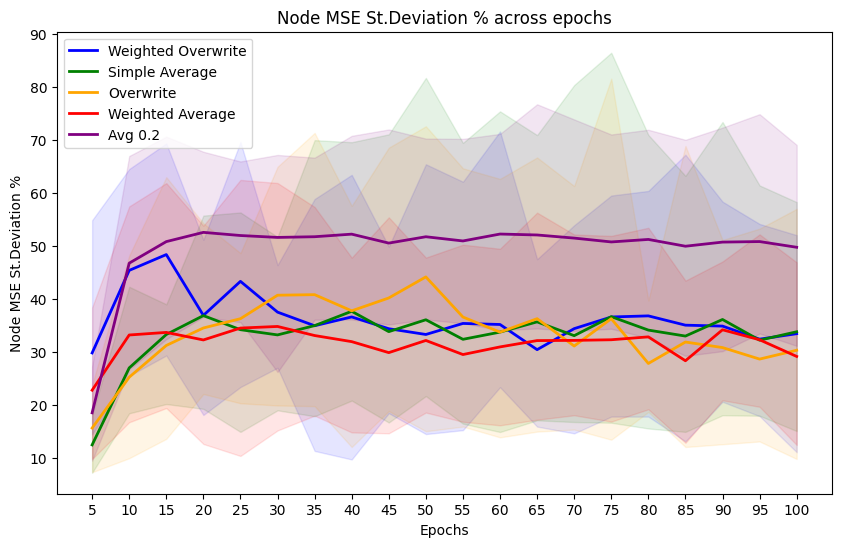

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

index = list(range(N_STEPS))
x_ticks = [(x+1)*STEP_SIZE for x in index]

for exp, color in zip(experiments.keys(), iter(colors)):
    mean, low, high = get_min_max_mean_series(variances[exp])
    ax.plot(mean, linewidth=2, label=experiments[exp], color=color)
    ax.fill_between(index, low, high, alpha=0.1, color=color)
# ax.set_yscale("log")
ax.set_title("Node MSE St.Deviation % across epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Node MSE St.Deviation %")

ax.set_xticks(index, labels=x_ticks)
ax.legend()

plt.show()
# fig.savefig("test.svg", format="svg", dpi=500)

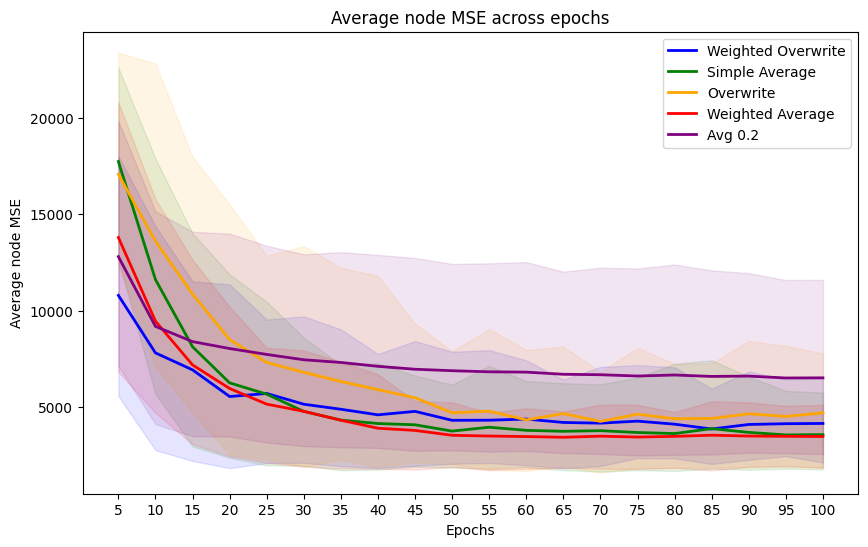

In [21]:

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,6))

index = list(range(N_STEPS))
x_ticks = [(x+1)*STEP_SIZE for x in index]

for exp, color in zip(experiments.keys(), iter(colors)):
    mean, low, high = get_min_max_mean_series(averages[exp])
    ax.plot(mean, linewidth=2, label=experiments[exp], color=color)
    ax.fill_between(index, low, high, alpha=0.1, color=color)

ax.set_title("Average node MSE across epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Average node MSE")
# ax.set_yscale("log")
ax.set_xticks(index, labels=x_ticks)
ax.legend()

Path("../plots/speed").mkdir(parents=True, exist_ok=True)
# plt.savefig("plots/speed/merge_strategies_1k.svg", format="svg", dpi=500, bbox_inches='tight')

In [22]:
import pandas as pd

def get_all_exp_metric(metric):
  all_exp_metric = pd.DataFrame()
  for _, exp_data in enumerate(metric):
    exp_metric = pd.DataFrame(exp_data)
    exp_metric.columns = [f"node_{nid}" for nid in exp_metric.columns]
    exp_metric = exp_metric.transpose()
    all_exp_metric = pd.concat([all_exp_metric, exp_metric])
  # average and standard deviation over experiment runs
  avg_exp_metric = (
    all_exp_metric.groupby(all_exp_metric.index).mean()
  ).transpose()
  std_exp_metric = (
    all_exp_metric.groupby(all_exp_metric.index).std()
  ).transpose()
  return all_exp_metric, avg_exp_metric, std_exp_metric

### RMSE

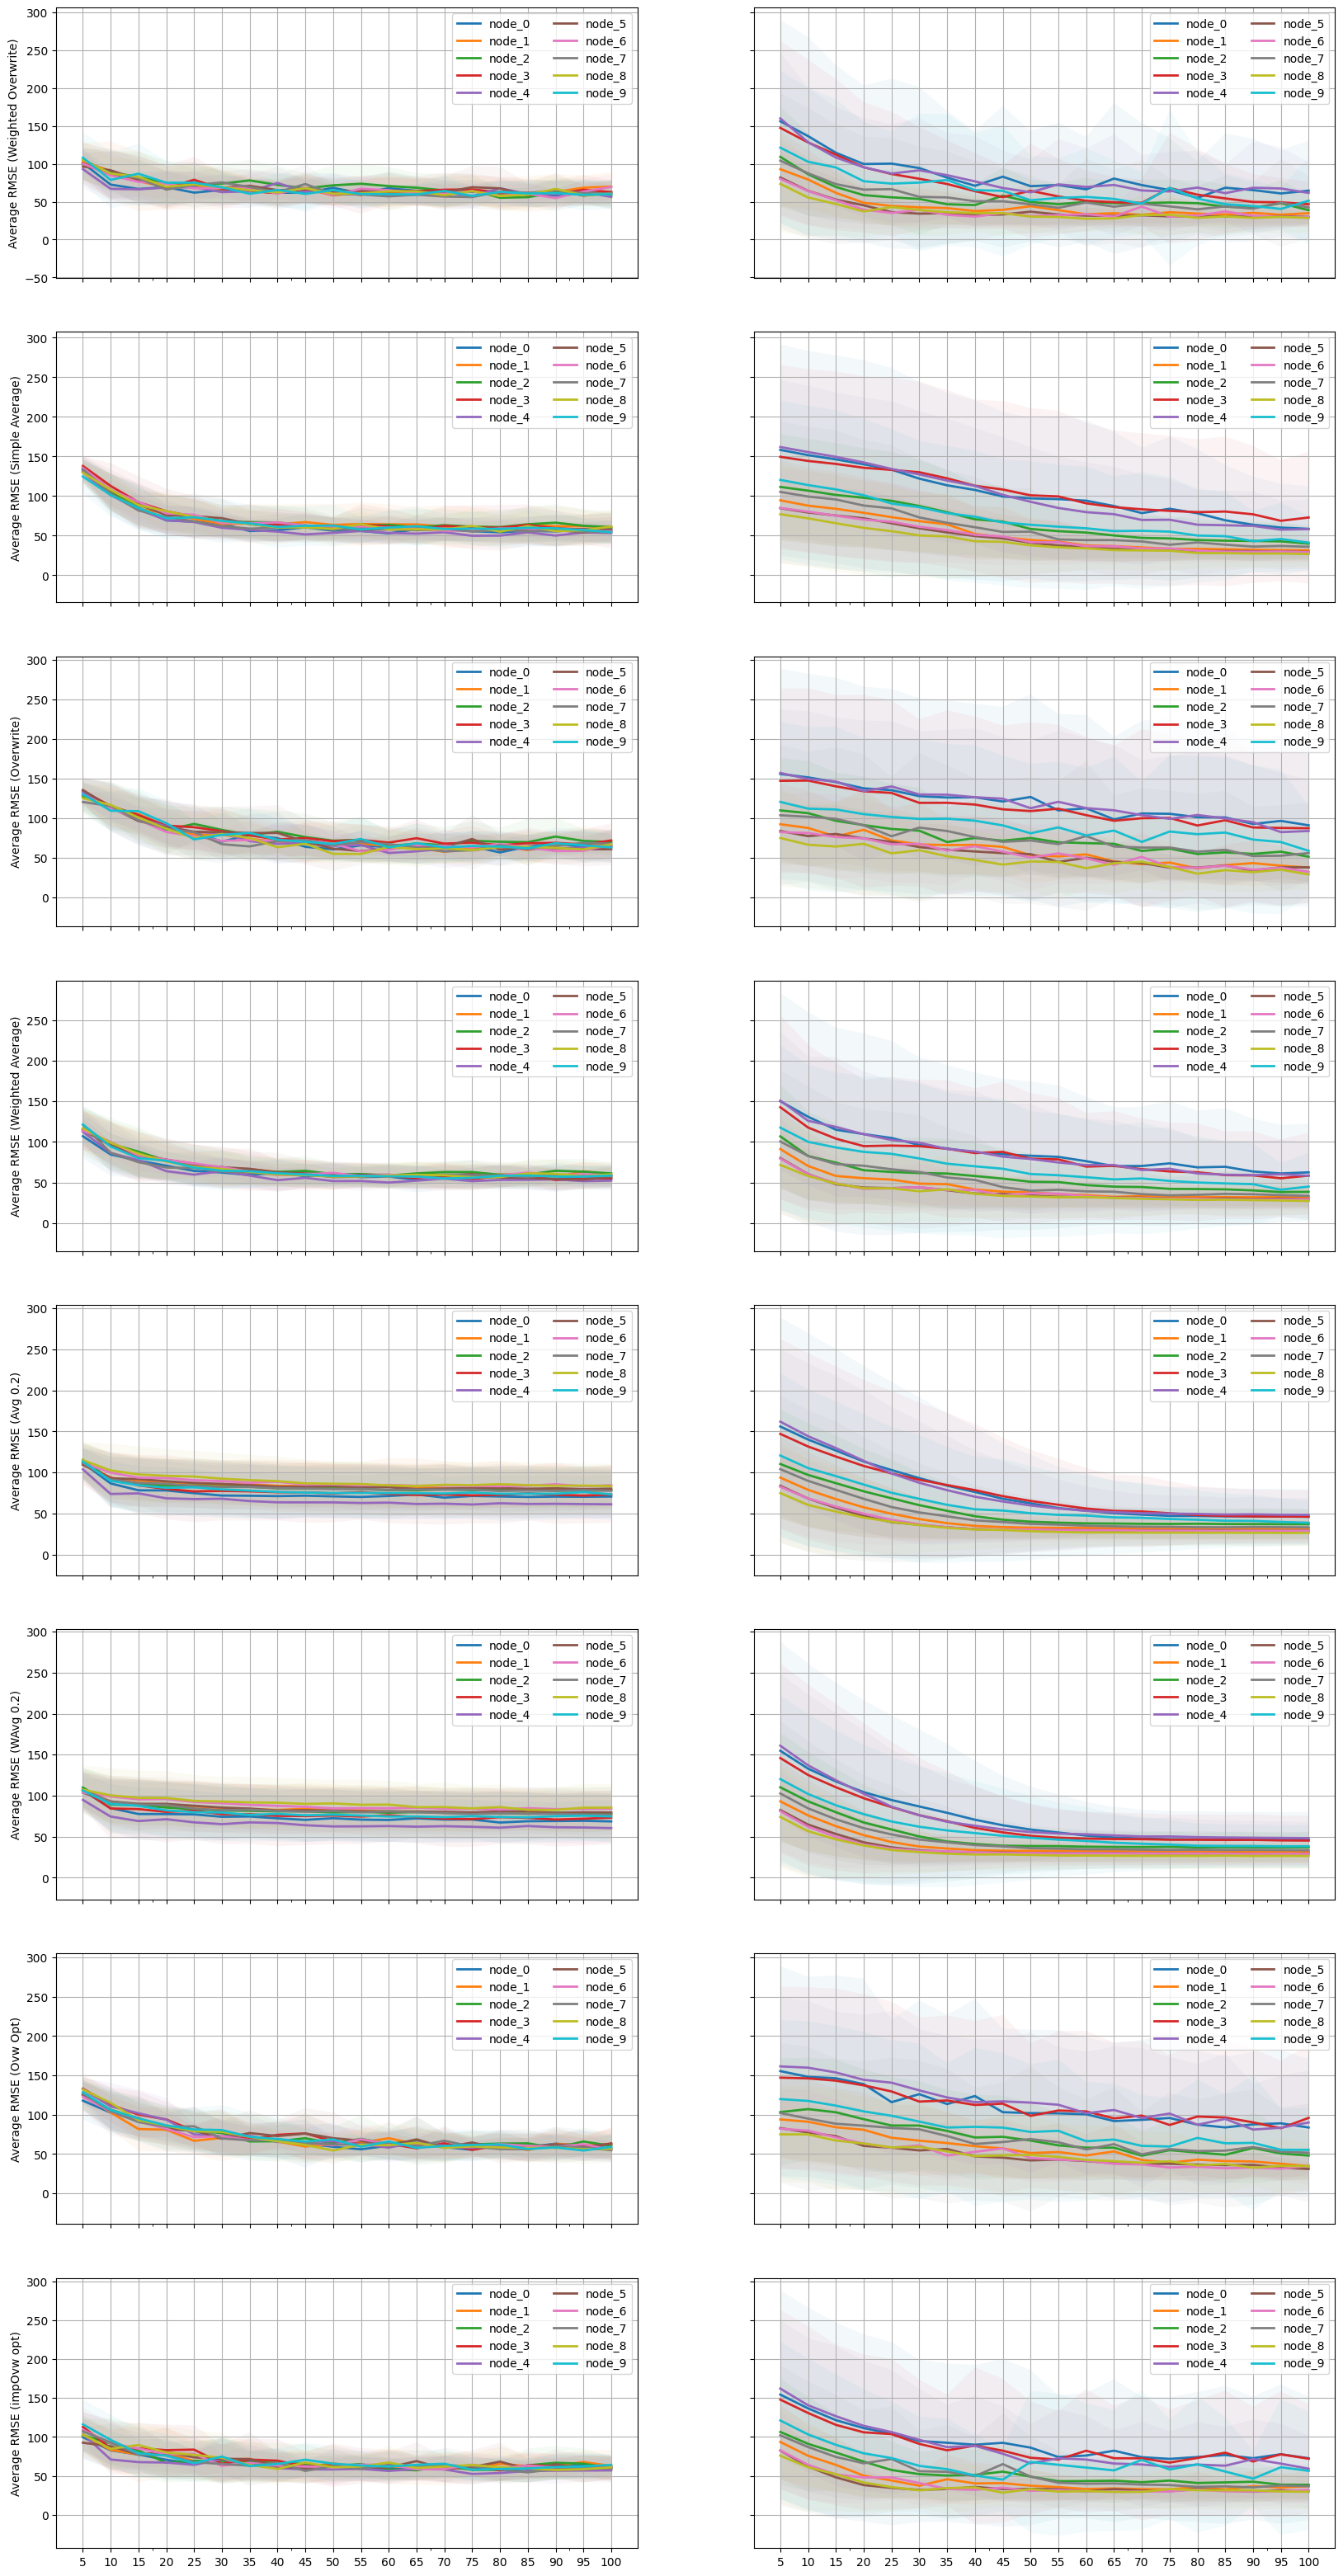

In [23]:
rmse = {
    exp: [
        get_node_metric_by_epoch(history, "rmse")
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}
training_rmse = {
    exp: [
        get_node_training_metric_by_epoch(history, "root_mean_squared_error")
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}

_, axs = plt.subplots(
  nrows = len(experiments), 
  ncols = 2,
  figsize = (20, 5 * len(experiments)),
  sharex = True,
  sharey = "row"
)
idx = 0
for exp, exp_name in experiments.items():
  # test and training mse
  _, avg_exp_mse, std_exp_mse = get_all_exp_metric(rmse[exp])
  _, avg_exp_trmse, std_exp_trmse = get_all_exp_metric(training_rmse[exp])
  # plot (test)
  avg_exp_mse.plot(
    linewidth = 2,
    ax = axs[idx,0],
    grid = True
  )
  for node in avg_exp_mse:
    axs[idx,0].fill_between(
      x = avg_exp_mse.index,
      y1 = avg_exp_mse[node] - std_exp_mse[node],
      y2 = avg_exp_mse[node] + std_exp_mse[node],
      alpha = 0.05
    )
  # plot (training)
  avg_exp_trmse.plot(
    linewidth = 2,
    ax = axs[idx,1],
    grid = True
  )
  for node in avg_exp_trmse:
    axs[idx,1].fill_between(
      x = avg_exp_trmse.index,
      y1 = avg_exp_trmse[node] - std_exp_trmse[node],
      y2 = avg_exp_trmse[node] + std_exp_trmse[node],
      alpha = 0.05
    )
  # axis properties
  axs[idx,0].set_ylabel(f"Average RMSE ({exp_name})")
  axs[idx,0].legend(ncol = 2)
  axs[idx,1].legend(ncol = 2)
  idx += 1
# x-axis ticks
x_ticks = [(x+1)*STEP_SIZE for x in avg_exp_mse.index]
_ = axs[-1,-1].set_xticks(avg_exp_mse.index, labels = x_ticks)

### MSE

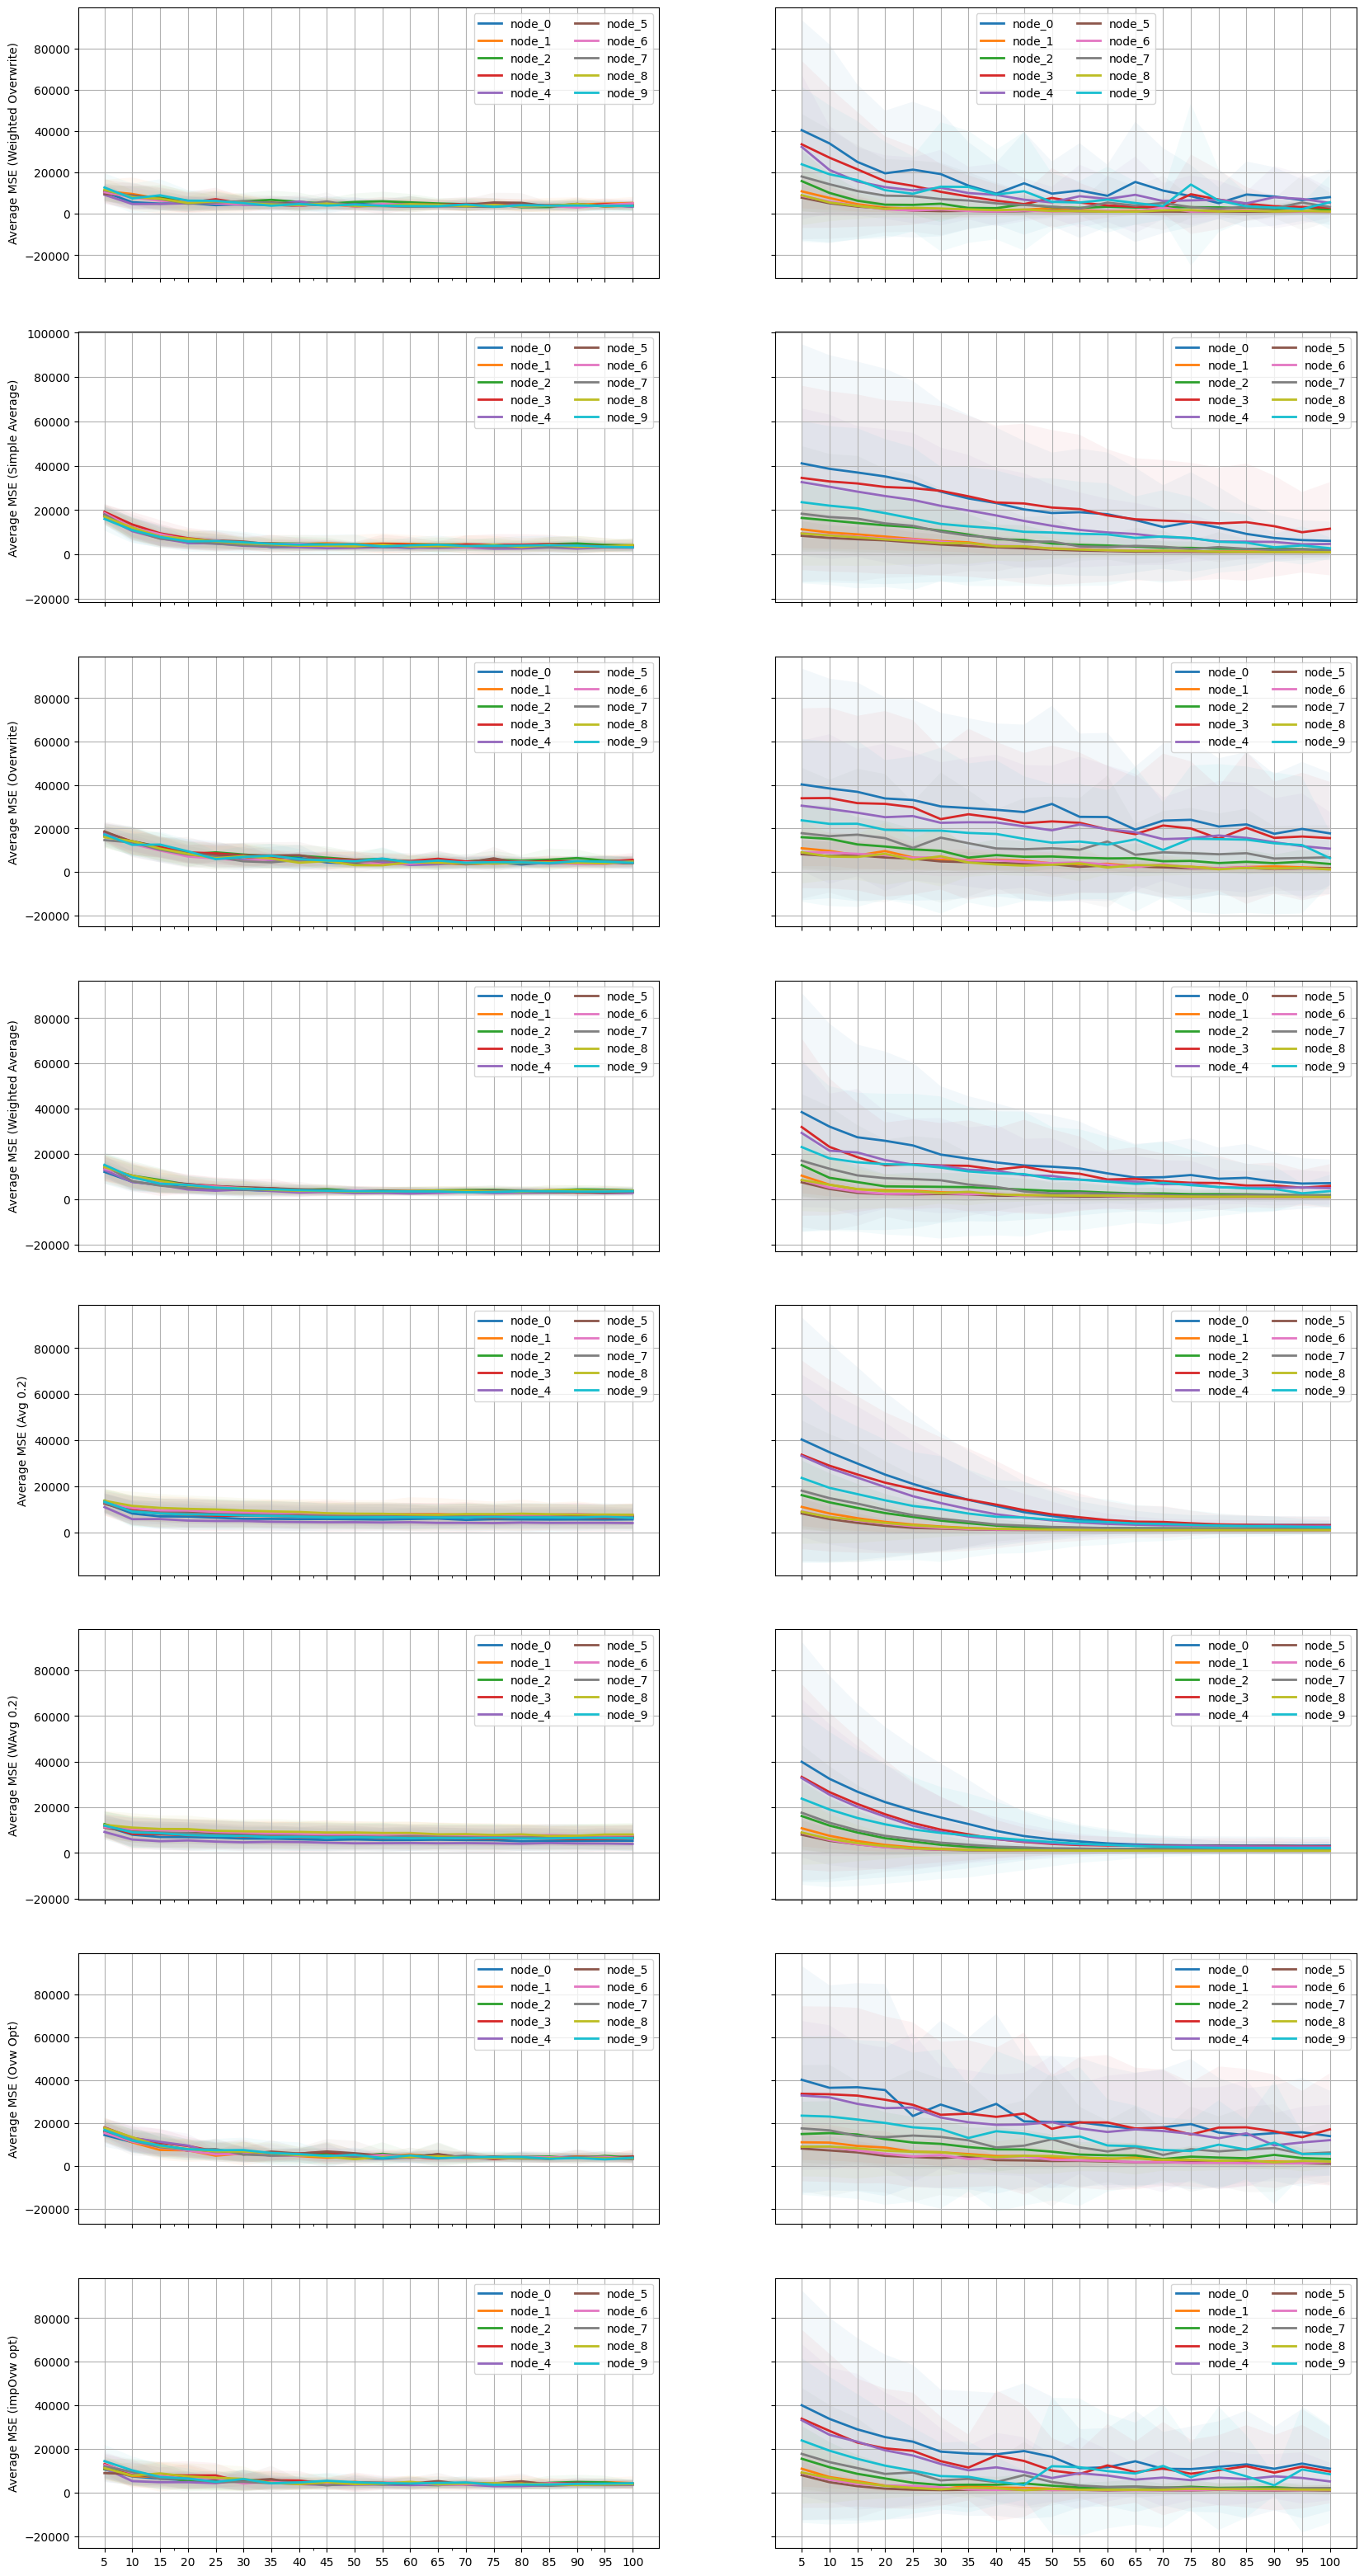

In [24]:
mse = {
    exp: [
        get_node_metric_by_epoch(history, "mse")
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}
training_mse = {
    exp: [
        get_node_training_metric_by_epoch(history, "mse")
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}

_, axs = plt.subplots(
  nrows = len(experiments), 
  ncols = 2,
  figsize = (20, 5 * len(experiments)),
  sharex = True,
  sharey = "row"
)
idx = 0
for exp, exp_name in experiments.items():
  # test and training mse
  _, avg_exp_mse, std_exp_mse = get_all_exp_metric(mse[exp])
  _, avg_exp_trmse, std_exp_trmse = get_all_exp_metric(training_mse[exp])
  # plot (test)
  avg_exp_mse.plot(
    linewidth = 2,
    ax = axs[idx,0],
    grid = True
  )
  for node in avg_exp_mse:
    axs[idx,0].fill_between(
      x = avg_exp_mse.index,
      y1 = avg_exp_mse[node] - std_exp_mse[node],
      y2 = avg_exp_mse[node] + std_exp_mse[node],
      alpha = 0.05
    )
  # plot (training)
  avg_exp_trmse.plot(
    linewidth = 2,
    ax = axs[idx,1],
    grid = True
  )
  for node in avg_exp_trmse:
    axs[idx,1].fill_between(
      x = avg_exp_trmse.index,
      y1 = avg_exp_trmse[node] - std_exp_trmse[node],
      y2 = avg_exp_trmse[node] + std_exp_trmse[node],
      alpha = 0.05
    )
  # axis properties
  axs[idx,0].set_ylabel(f"Average MSE ({exp_name})")
  axs[idx,0].legend(ncol = 2)
  axs[idx,1].legend(ncol = 2)
  idx += 1
# x-axis ticks
x_ticks = [(x+1)*STEP_SIZE for x in avg_exp_mse.index]
_ = axs[-1,-1].set_xticks(avg_exp_mse.index, labels = x_ticks)

In [25]:
loss = {
    exp: [
        get_node_training_metric_by_epoch(history, "loss")
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}

mape = {
    exp: [
        get_node_training_metric_by_epoch(history, "mape")
        for history in histories[exp]
    ]
    for exp in experiments.keys()
}

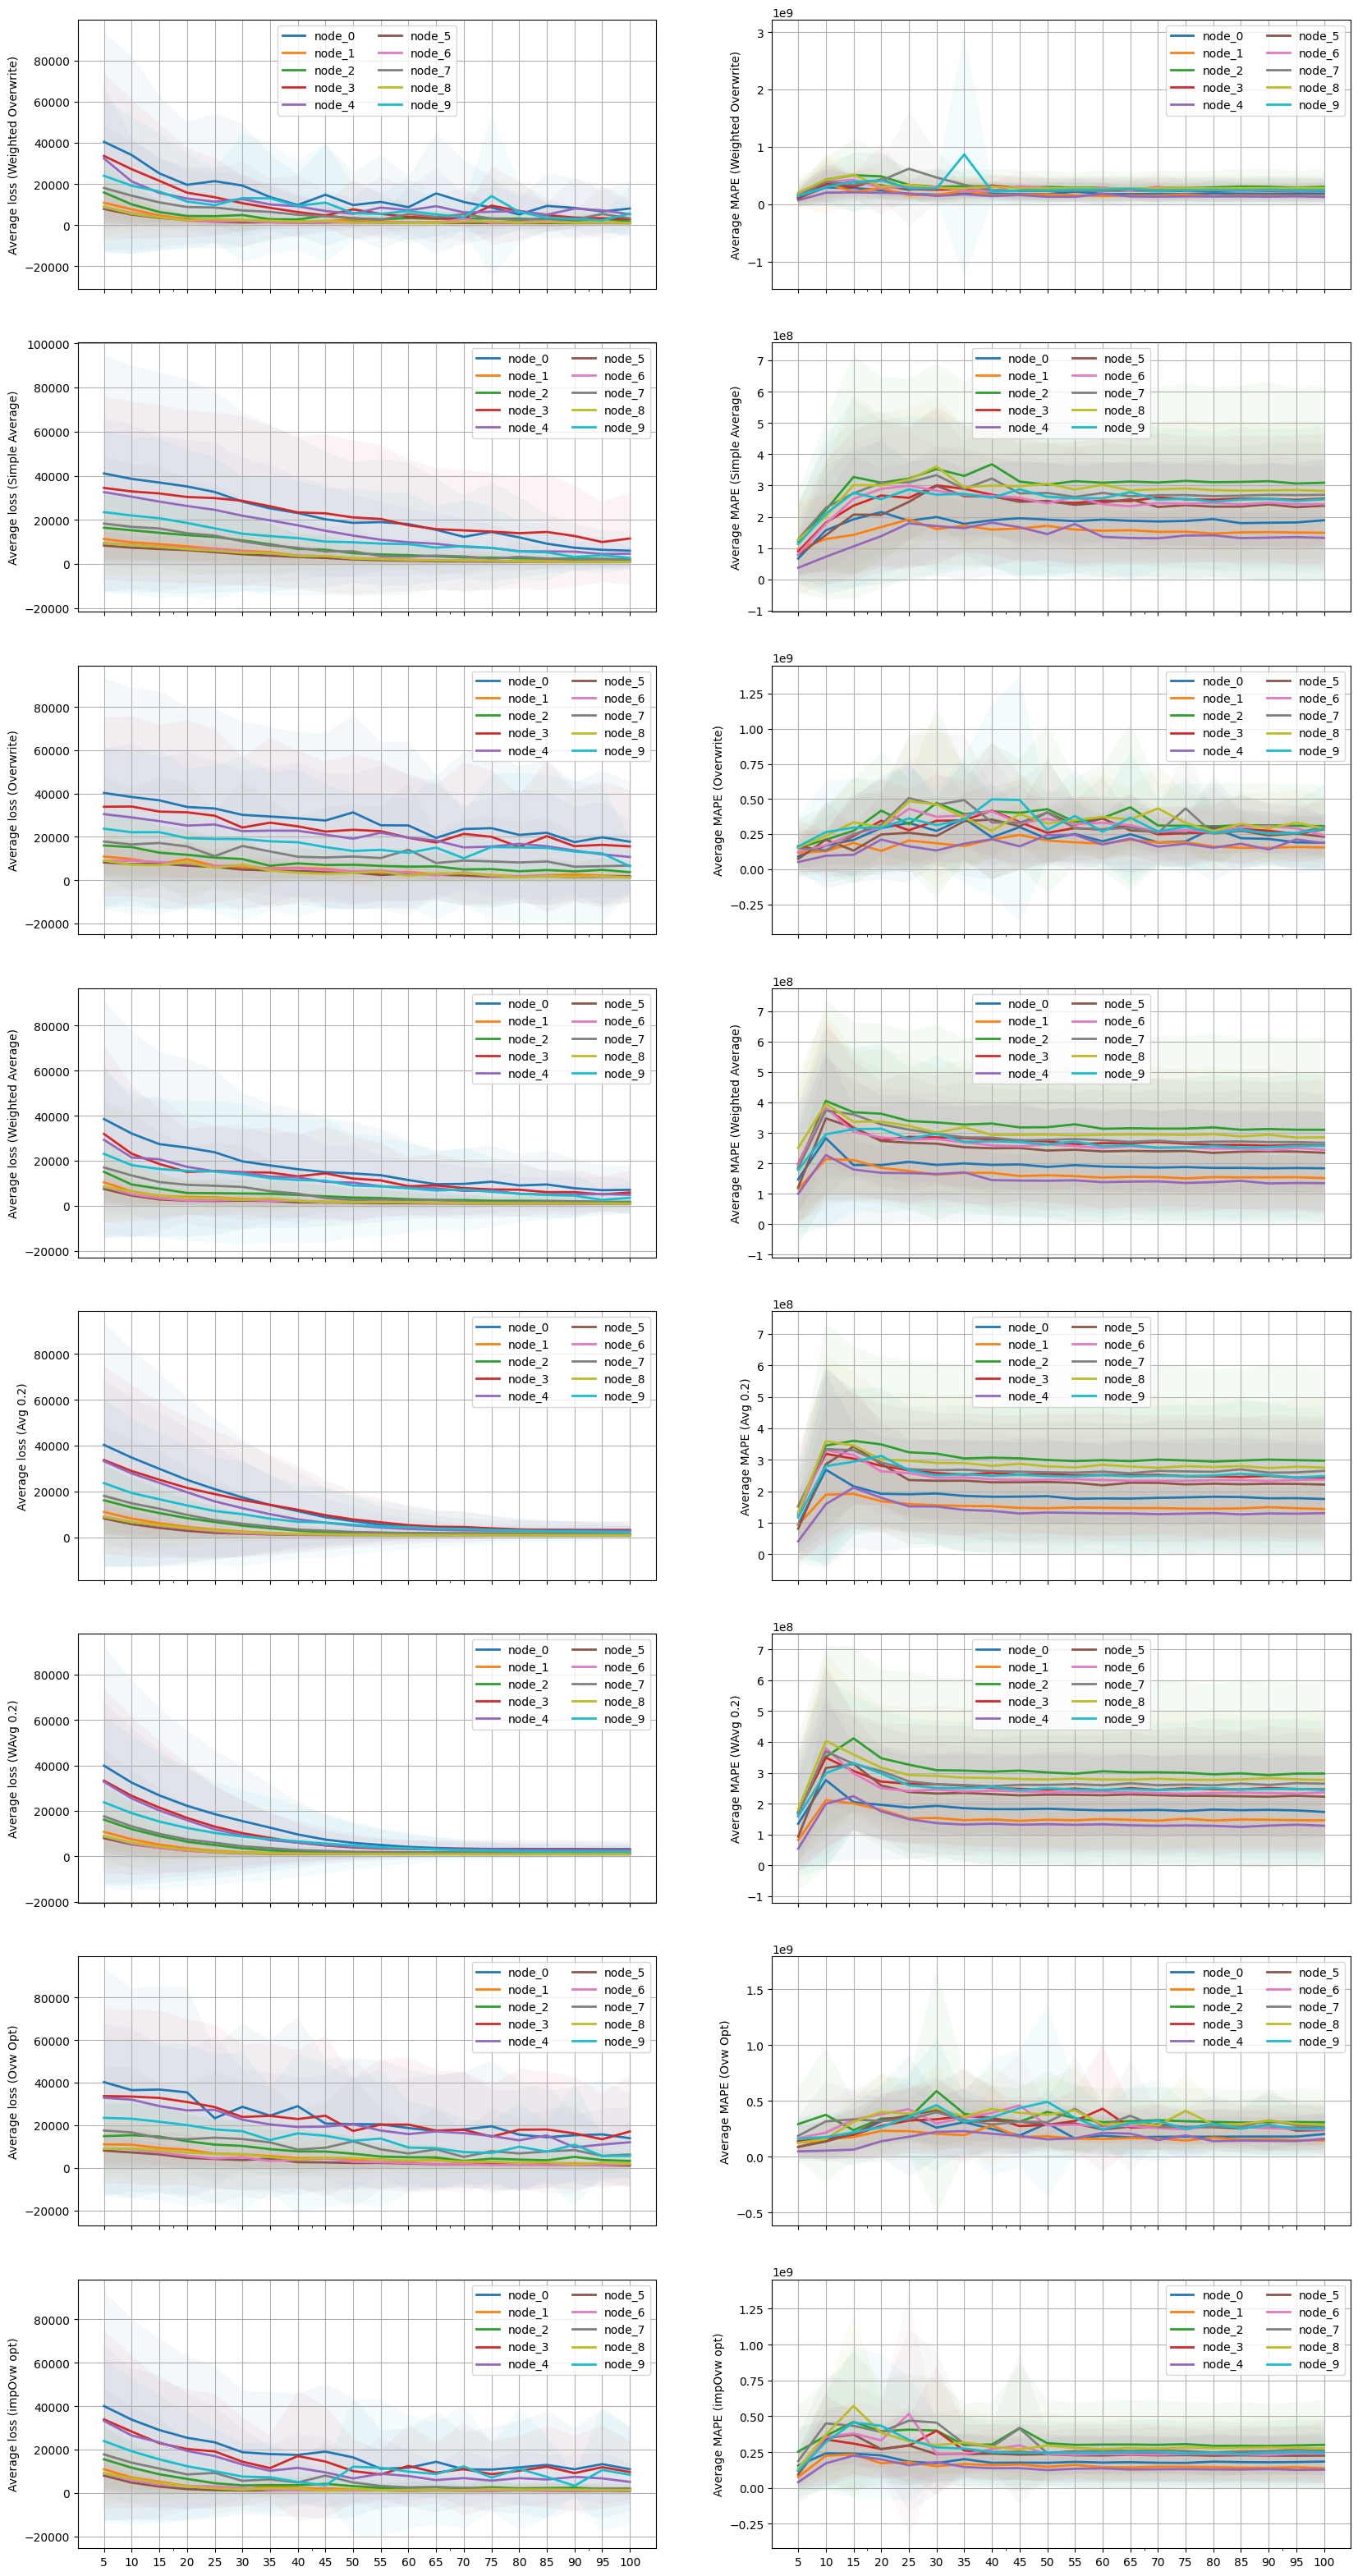

In [26]:
_, axs = plt.subplots(
  nrows = len(experiments), 
  ncols = 2,
  figsize = (20, 5 * len(experiments)),
  sharex = True
)
idx = 0
for exp, exp_name in experiments.items():
  # training loss and mape
  _, avg_exp_trloss, std_exp_trloss = get_all_exp_metric(loss[exp])
  _, avg_exp_trmape, std_exp_trmape = get_all_exp_metric(mape[exp])
  # plot (loss)
  avg_exp_trloss.plot(
    linewidth = 2,
    ax = axs[idx,0],
    grid = True
  )
  for node in avg_exp_trloss:
    axs[idx,0].fill_between(
      x = avg_exp_trloss.index,
      y1 = avg_exp_trloss[node] - std_exp_trloss[node],
      y2 = avg_exp_trloss[node] + std_exp_trloss[node],
      alpha = 0.05
    )
  # plot (mape)
  avg_exp_trmape.plot(
    linewidth = 2,
    ax = axs[idx,1],
    grid = True
  )
  for node in avg_exp_trmape:
    axs[idx,1].fill_between(
      x = avg_exp_trmape.index,
      y1 = avg_exp_trmape[node] - std_exp_trmape[node],
      y2 = avg_exp_trmape[node] + std_exp_trmape[node],
      alpha = 0.05
    )
  # axis properties
  axs[idx,0].set_ylabel(f"Average loss ({exp_name})")
  axs[idx,0].legend(ncol = 2)
  # axis properties
  axs[idx,1].set_ylabel(f"Average MAPE ({exp_name})")
  axs[idx,1].legend(ncol = 2)
  idx += 1
# x-axis ticks
x_ticks = [(x+1)*STEP_SIZE for x in avg_exp_mse.index]
_ = axs[-1,-1].set_xticks(avg_exp_mse.index, labels = x_ticks)
